## Load the model

In [1]:
import argparse
import os
import logging
import sys
import itertools

import torch
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR

from vision.utils.misc import str2bool, Timer, freeze_net_layers, store_labels
from vision.ssd.ssd import MatchPrior
from vision.ssd.vgg_ssd import create_vgg_ssd
from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd
from vision.ssd.mobilenetv1_ssd_lite import create_mobilenetv1_ssd_lite
from vision.ssd.mobilenet_v2_ssd_lite import create_mobilenetv2_ssd_lite
from vision.ssd.squeezenet_ssd_lite import create_squeezenet_ssd_lite
from vision.datasets.voc_dataset import VOCDataset
from vision.datasets.open_images import OpenImagesDataset
from vision.nn.multibox_loss import MultiboxLoss
from vision.ssd.config import vgg_ssd_config
from vision.ssd.config import mobilenetv1_ssd_config
from vision.ssd.config import squeezenet_ssd_config
from vision.ssd.data_preprocessing import TrainAugmentation, TestTransform

In [2]:
dataset_path = "/home/jbang36/data/VOCdevkit/VOC2007"
validation_path = "/home/jbang36/data/VOCdevkit/VOC2007"
base_net = "models/vgg16_reducedfc.pth"
batch_size = 24
num_workers = 4
num_epochs = 200
checkpoint_folder = 'models/'
lr = 1e-3
momentum = 0.9
weight_decay =5e-4
validation_epochs = 5
debug_steps = 100

timer = Timer()

In [3]:
## load the dataset
create_net = create_vgg_ssd
config = vgg_ssd_config

train_transform = TrainAugmentation(config.image_size, config.image_mean,  
                                    config.image_std)
target_transform = MatchPrior(config.priors, config.center_variance,
                                  config.size_variance, 0.5)

test_transform = TestTransform(config.image_size, config.image_mean, 
                               config.image_std)

    




In [ ]:
## Train Augmentation
## Test Augmentation - both simply does normalization, random cropping, expand, shrinking, etc to help with
## training the data




In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
## Load the model

num_classes = 4
net = create_net(num_classes)
min_loss = -10000.0
last_epoch = -1
base_net_lr = lr
extra_layers_lr = lr


print("Base net is frozen..")
freeze_net_layers(net.base_net)
params = itertools.chain(net.source_layer_add_ons.parameters(), net.extras.parameters(),
                         net.regression_headers.parameters(), net.classification_headers.parameters())
params = [
    {'params': itertools.chain(
        net.source_layer_add_ons.parameters(),
        net.extras.parameters()
    ), 'lr': extra_layers_lr},
    {'params': itertools.chain(
        net.regression_headers.parameters(),
        net.classification_headers.parameters()
    )}
]


net.init_from_base_net(base_net)
## later when we need to load from pretrained ssd...
"""
net.init_from_pretrained_ssd(args.pretrained_ssd)
"""

net.to(DEVICE)

print("Done loading to GPU")


Base net is frozen..
Done loading to GPU


In [7]:
## Load the rest (optimizer, loss function, etc)

criterion = MultiboxLoss(config.priors, iou_threshold=0.5, neg_pos_ratio=3,
                         center_variance=0.1, size_variance=0.2, device=DEVICE)
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9,
                            weight_decay=5e-4)


milestones = [int(v.strip()) for v in "80,100".split(",")]
scheduler = MultiStepLR(optimizer, milestones=milestones,
                        gamma=0.1, last_epoch=last_epoch)
   

In [8]:
## train the model 

def train(loader, net, criterion, optimizer, device, debug_steps=100, epoch=-1):
    net.train(True)
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    for i, data in enumerate(loader):
        images, boxes, labels = data
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        confidence, locations = net(images)
        regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)  # TODO CHANGE BOXES
        loss = regression_loss + classification_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
        if i and i % debug_steps == 0:
            avg_loss = running_loss / debug_steps
            avg_reg_loss = running_regression_loss / debug_steps
            avg_clf_loss = running_classification_loss / debug_steps

            running_loss = 0.0
            running_regression_loss = 0.0
            running_classification_loss = 0.0

In [9]:
### Now we need to try on UA-detrac

%load_ext autoreload
%autoreload 2

%pylab inline
import os
import cv2
import time
import numpy as np
import pandas as pd

import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image


home_dir = '/home/jbang36/eva'
data_dir = os.path.join(home_dir, 'data', 'ua_detrac',  'DETRAC-Images')
data_dir

home_dir

filter_path = os.path.join(home_dir, 'filters')
loader_path = os.path.join(home_dir, 'loaders')


sys.path.append(home_dir)
sys.path.append(loader_path)
sys.path.append(filter_path)


Populating the interactive namespace from numpy and matplotlib


In [10]:
util_path = os.path.join(home_dir, 'others', 'jupyter', 'core')

sys.path.append(util_path)

In [11]:
root = '/home/jbang36/eva'

In [12]:
from utils import *
## I don't think you need to normalize....

X_train_norm, X_test_norm, Y_train_dict, Y_test_dict = get_uadetrac()
anno_dir = os.path.join(root,'data', 'ua_detrac','small-annotations')
boxes_dataset = get_boxes(anno_dir, width = 300, height = 300)
y_train = Y_train_dict['vehicle_type']
y_test = Y_test_dict['vehicle_type']

division = len(X_train_norm)
y_train_boxes = boxes_dataset[:division]
y_test_boxes = boxes_dataset[division:]


  0%|          | 7/10421 [00:00<02:47, 62.23it/s]

image directory is  /home/jbang36/eva/data/ua_detrac/small-data
Length of file_names: 10421


100%|██████████| 10421/10421 [01:19<00:00, 131.60it/s]
0it [00:00, ?it/s]

.ipynb_checkpoints  will be ignored...


1it [00:00,  2.75it/s]

MVI_20011.xml
mvi length: 664
car_labels length: 664


2it [00:00,  2.68it/s]

MVI_20012.xml
mvi length: 1600
car_labels length: 1600
MVI_20032.xml
mvi length: 2037
car_labels length: 2037


4it [00:01,  3.31it/s]

MVI_20033.xml
mvi length: 2821
car_labels length: 2821


5it [00:01,  3.17it/s]

MVI_20034.xml
mvi length: 3621
car_labels length: 3621


6it [00:01,  2.78it/s]

MVI_20035.xml
mvi length: 4421
car_labels length: 4421


7it [00:02,  2.84it/s]

MVI_20051.xml
mvi length: 5327
car_labels length: 5327


8it [00:02,  2.96it/s]

MVI_20052.xml
mvi length: 6021
car_labels length: 6021


10it [00:02,  3.61it/s]

MVI_20061.xml
mvi length: 6821
car_labels length: 6821
MVI_20062.xml
mvi length: 7621
car_labels length: 7621


11it [00:03,  3.76it/s]

MVI_20063.xml
mvi length: 8421
car_labels length: 8421


12it [00:03,  2.81it/s]

MVI_20064.xml
mvi length: 9221
car_labels length: 9221


13it [00:04,  2.17it/s]

MVI_20065.xml
mvi length: 10421
car_labels length: 10421
10421
8336


skipping .ipynb_checkpoints


In [13]:
print(y_train[0])

['car', 'car', 'car', 'car', 'car', 'car', 'car']


In [14]:
## We need to make val dataset...

val_division = int(0.8 * len(X_train_norm))
X_val_norm = X_train_norm[val_division:]
X_train_norm = X_train_norm[:val_division]
y_val_boxes = y_train_boxes[val_division:]
y_train_boxes = y_train_boxes[:val_division]
y_val = y_train[val_division:]
y_train = y_train[:val_division]


In [15]:
train_dataset = UADataset_lite(transform=train_transform, target_transform=target_transform)
X_train = X_train_norm * 255.0
X_train = X_train.astype(np.uint8)

train_dataset.set_x(X_train)
train_dataset.set_y(y_train)
train_dataset.set_y_boxes(y_train_boxes)



In [16]:
X_val = X_val_norm * 255.0
X_val = X_val.astype(np.uint8)
val_dataset = UADataset_lite(transform=train_transform, target_transform=target_transform)
val_dataset.set_x(X_val_norm)
val_dataset.set_y(y_val)
val_dataset.set_y_boxes(y_val_boxes)

X_test = X_test_norm * 255.0
X_test = X_test.astype(np.uint8)
test_dataset = UADataset_lite(transform=train_transform, target_transform=target_transform)
test_dataset.set_x(X_test)
test_dataset.set_y(y_test)
test_dataset.set_y_boxes(y_test_boxes)

In [26]:
a = torch.Tensor([[1,2], [1,2], [1,2], [1,2], [1,2], [1,2], [1,2], [1,2], [1,2], [1,2]])
a = a[..., :5]
print(a.size())
print(a)

torch.Size([10, 2])
tensor([[1., 2.],
        [1., 2.],
        [1., 2.],
        [1., 2.],
        [1., 2.],
        [1., 2.],
        [1., 2.],
        [1., 2.],
        [1., 2.],
        [1., 2.]])


In [30]:
for i, data in enumerate(train_dataset):
    images, boxes, labels = data
    print(labels)
    break

inside matchprior
boxes size torch.Size([7, 4])
labels size torch.Size([7])
center_form_priors size torch.Size([8732, 4])
inside box_utils assign_priors...
gt boxes size torch.Size([7, 4])
corner_form_priors size torch.Size([8732, 4])
ious size torch.Size([8732, 7])
---------
torch.Size([8732])
torch.Size([7])
after assigning priors
boxes size torch.Size([8732, 4])
labels size torch.Size([8732])
tensor([0, 0, 0,  ..., 0, 0, 0])


In [ ]:
## Need to look into train_transform, target_transform because the images are becoming malformed....
## train_transform = 
"""
train_transform = TrainAugmentation(config.image_size, config.image_mean,  
                                    config.image_std)
target_transform = MatchPrior(config.priors, config.center_variance,
                                  config.size_variance, 0.5)

test_transform = TestTransform(config.image_size, config.image_mean, 
                               config.image_std)

TrainAugmentation, TestTransform are in data_preprocessing
MatchPrior is in ssd



"""



In [15]:
## convert to loader 
batch_size = 24
train_loader = DataLoader(train_dataset, batch_size,
                          num_workers= 4,
                          shuffle=True)

val_loader = DataLoader(val_dataset, batch_size,
                          num_workers= 4,
                          shuffle=True)


torch.Size([24, 3, 300, 300])
torch.Size([24, 8732, 4])
torch.Size([24, 8732])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([3, 300, 300])
torch.Size([300, 300, 3])


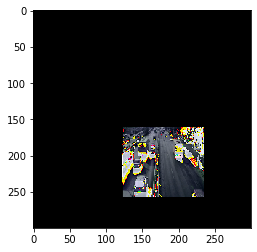

torch.Size([24, 3, 300, 300])
torch.Size([24, 8732, 4])
torch.Size([24, 8732])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([3, 300, 300])
torch.Size([300, 300, 3])


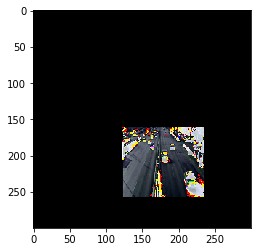

torch.Size([24, 3, 300, 300])
torch.Size([24, 8732, 4])
torch.Size([24, 8732])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([3, 300, 300])
torch.Size([300, 300, 3])


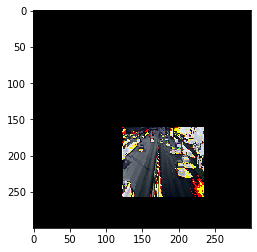

torch.Size([24, 3, 300, 300])
torch.Size([24, 8732, 4])
torch.Size([24, 8732])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([3, 300, 300])
torch.Size([300, 300, 3])


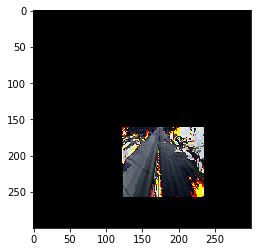

torch.Size([24, 3, 300, 300])
torch.Size([24, 8732, 4])
torch.Size([24, 8732])
tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  1.4016, -16.6644,   4.7273,  ...,   0.0000,   0.0000,   0.0000],
        [ -9.3016,  -4.7441,   2.4703,  ...,   0.0000,   0.0000,   0.0000],
        [-10.7054,  -5.3599,   7.7397,  ...,   0.0000,   0.0000,   0.0000]])
torch.Size([3, 300, 300])
torch.Size([300, 300, 3])


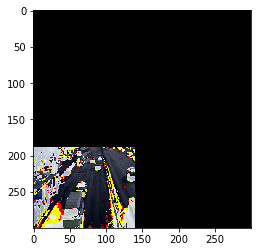

torch.Size([24, 3, 300, 300])
torch.Size([24, 8732, 4])
torch.Size([24, 8732])
tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [-73.7163, -72.4189, -70.1200,  ..., -40.0372, -41.8400, -43.7350],
        [-74.6767, -73.3634, -71.0779,  ..., -40.8943, -40.6003, -40.5047],
        [-75.8185, -74.3244, -71.8867,  ..., -42.0837, -38.5451, -35.5569]])
torch.Size([3, 300, 300])
torch.Size([300, 300, 3])


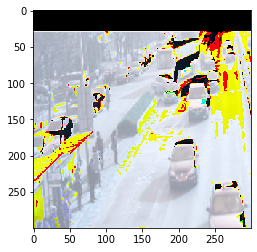

torch.Size([24, 3, 300, 300])
torch.Size([24, 8732, 4])
torch.Size([24, 8732])
tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [ -7.9767,   5.2609,  20.0806,  ..., -52.3149, -51.1483, -50.6602],
        [  9.6745,  18.1743,  24.2315,  ..., -35.4350, -33.7986, -32.9021],
        [ 17.2864,  24.1592,  24.9927,  ..., -21.6383, -20.0971, -19.2006]])
torch.Size([3, 300, 300])
torch.Size([300, 300, 3])


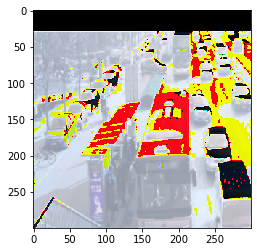

torch.Size([24, 3, 300, 300])
torch.Size([24, 8732, 4])
torch.Size([24, 8732])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([3, 300, 300])
torch.Size([300, 300, 3])


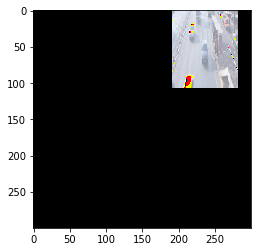

torch.Size([24, 3, 300, 300])
torch.Size([24, 8732, 4])
torch.Size([24, 8732])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([3, 300, 300])
torch.Size([300, 300, 3])


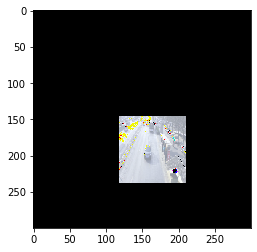

torch.Size([24, 3, 300, 300])
torch.Size([24, 8732, 4])
torch.Size([24, 8732])
tensor([[ 24.9278,   5.6512,  -2.2808,  ..., -58.0363, -54.8313, -50.0613],
        [ 15.4739,   3.3499,  -1.2321,  ..., -58.2600, -56.9114, -53.1113],
        [  3.0418,  -0.2657,  -0.2292,  ..., -57.4813, -58.6718, -57.1613],
        ...,
        [ 12.8387,  16.8534,  13.3462,  ..., -12.9834, -13.4011, -13.3613],
        [ 11.8187,  17.1690,  15.1912,  ..., -12.4030, -13.3463, -14.4513],
        [  6.9387,  15.6837,  18.5970,  ..., -12.4030, -13.4713, -15.0613]])
torch.Size([3, 300, 300])
torch.Size([300, 300, 3])


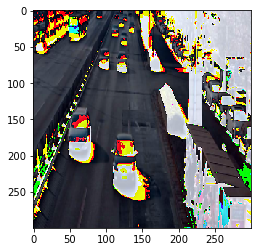

torch.Size([24, 3, 300, 300])
torch.Size([24, 8732, 4])
torch.Size([24, 8732])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -3.9405, -5.1563,  4.7556],
        [ 0.0000,  0.0000,  0.0000,  ..., 11.1174,  9.7381,  5.9332],
        [ 0.0000,  0.0000,  0.0000,  ..., 13.4037, -3.8047, -3.3614]])
torch.Size([3, 300, 300])
torch.Size([300, 300, 3])


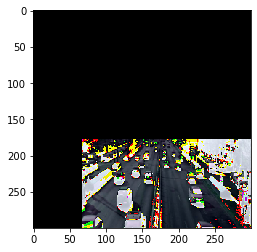

In [221]:
for i, (images, boxes, labels) in enumerate(train_loader):
    print(images.size())
    print(boxes.size())
    print(labels.size())
    tmp = images[0]
    print(tmp[0])
    print(tmp.size())
    tmp = tmp.permute(1,2,0)
    print(tmp.size())
    tmp = tmp.numpy().astype(np.uint8)
    plt.imshow(tmp)
    plt.show()
    
    if i == 10:
        break
    


In [27]:
## Validation while training

def test123(loader, net, criterion, device):
    
    return running_loss / num, running_regression_loss / num, running_classification_loss / num


In [16]:
## evaluate the model
## let's just import utils and do all evaluations here?
import time

st = time.time()

for epoch in range(last_epoch + 1, num_epochs):
    scheduler.step()
    train(train_loader, net, criterion, optimizer,
          device=DEVICE, debug_steps=debug_steps, epoch=epoch)

    if epoch % validation_epochs == 0 or epoch == num_epochs - 1:
        net.eval()
        running_loss = 0.0
        running_regression_loss = 0.0
        running_classification_loss = 0.0
        num = 0
        for _, data in enumerate(val_loader):
            images, boxes, labels = data
            images = images.to(DEVICE)
            boxes = boxes.to(DEVICE)
            labels = labels.to(DEVICE)
            num += 1
            with torch.no_grad():
                confidence, locations = net(images)
                regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)
                loss = regression_loss + classification_loss
            running_loss += loss.item()
            running_regression_loss += regression_loss.item()
            running_classification_loss += classification_loss.item()
        val_loss = running_loss / num
        val_regression_loss = running_regression_loss / num
        val_classification_loss = running_regression_loss / num
        print("epoch", epoch)
        print("  Validation Loss: {v:.4f}".format(v=val_loss))
        print("  Validatiion Regression Loss: {v:.4f}".format(v=val_regression_loss))
        print("  Validation Classification Loss: {v:.4f}".format(v=val_classification_loss))
        
        checkpoint_file_name = "vgg16-ssd:epoch" + str(epoch)
        model_path = os.path.join(checkpoint_folder, checkpoint_file_name)
        net.save(model_path)
        
print("Total time to train...", time.time() - st, "seconds")


/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch 0
  Validation Loss: 9.0459
  Validatiion Regression Loss: 3.4418
  Validation Classification Loss: 3.4418
epoch 5
  Validation Loss: 7.4516
  Validatiion Regression Loss: 3.4166
  Validation Classification Loss: 3.4166
epoch 10
  Validation Loss: 7.4049
  Validatiion Regression Loss: 3.4376
  Validation Classification Loss: 3.4376
epoch 15
  Validation Loss: 7.6271
  Validatiion Regression Loss: 3.5006
  Validation Classification Loss: 3.5006
epoch 20
  Validation Loss: 8.1445
  Validatiion Regression Loss: 3.5982
  Validation Classification Loss: 3.5982
epoch 25
  Validation Loss: 7.9936
  Validatiion Regression Loss: 3.4841
  Validation Classification Loss: 3.4841
epoch 30
  Validation Loss: 7.9757
  Validatiion Regression Loss: 3.5384
  Validation Classification Loss: 3.5384
epoch 35
  Validation Loss: 7.9445
  Validatiion Regression Loss: 3.5356
  Validation Classification Loss: 3.5356
epoch 40
  Validation Loss: 8.3351
  Validatiion Regression Loss: 3.5898
  Validation Clas

In [ ]:
### After training, modify the evaluation code to extract precision and recall



In [17]:
test_loader = DataLoader(test_dataset, batch_size,
                          num_workers= 4,
                          shuffle=False)


In [18]:
for _, data in enumerate(test_loader):
    images, boxes, labels = data
    images = images.to(DEVICE)
    boxes = boxes.to(DEVICE)
    labels = labels.to(DEVICE)
    with torch.no_grad():
        confidence, locations = net(images)
    break
    
## we now have images, boxes, labels, confidence, locations

In [20]:
locations.size()

torch.Size([24, 8732, 4])

In [53]:
import vision.utils as ssd_utils
## need to convert locations to boxes
# I think the center_form_to_corner_form might be wrong??


predicted_locations = locations.cpu()

predicted_boxes = ssd_utils.box_utils.convert_locations_to_boxes(predicted_locations, config.priors, config.center_variance, config.size_variance)
predicted_boxes = ssd_utils.box_utils.center_form_to_corner_form(predicted_boxes)

gt_locations = boxes.cpu() ## they have converted boxes to locations
gt_boxes = ssd_utils.box_utils.convert_locations_to_boxes(gt_locations, config.priors, config.center_variance, config.size_variance)


gt_boxes = ssd_utils.box_utils.center_form_to_corner_form(gt_boxes)

In [49]:
"""
gt_locations = boxes.cpu() ## they have converted boxes to locations
gt_boxes_center_form = ssd_utils.box_utils.convert_locations_to_boxes(gt_locations, config.priors, config.center_variance, config.size_variance)
gt_boxes_corner_form = ssd_utils.box_utils.center_form_to_corner_form(gt_boxes)
"""

In [54]:
gt_boxes[0][0] * 300

tensor([ 5.0847,  5.0209, 33.5593, 31.3808])

In [23]:
print(predicted_boxes.size())
print(gt_boxes.size())

torch.Size([24, 8732, 4])
torch.Size([24, 8732, 4])


In [25]:
## prep the data
images_cpu = images.cpu()
pos_mask = labels > 0

In [185]:
pos_mask.size()

torch.Size([24, 8732])

## Split by Frame

24


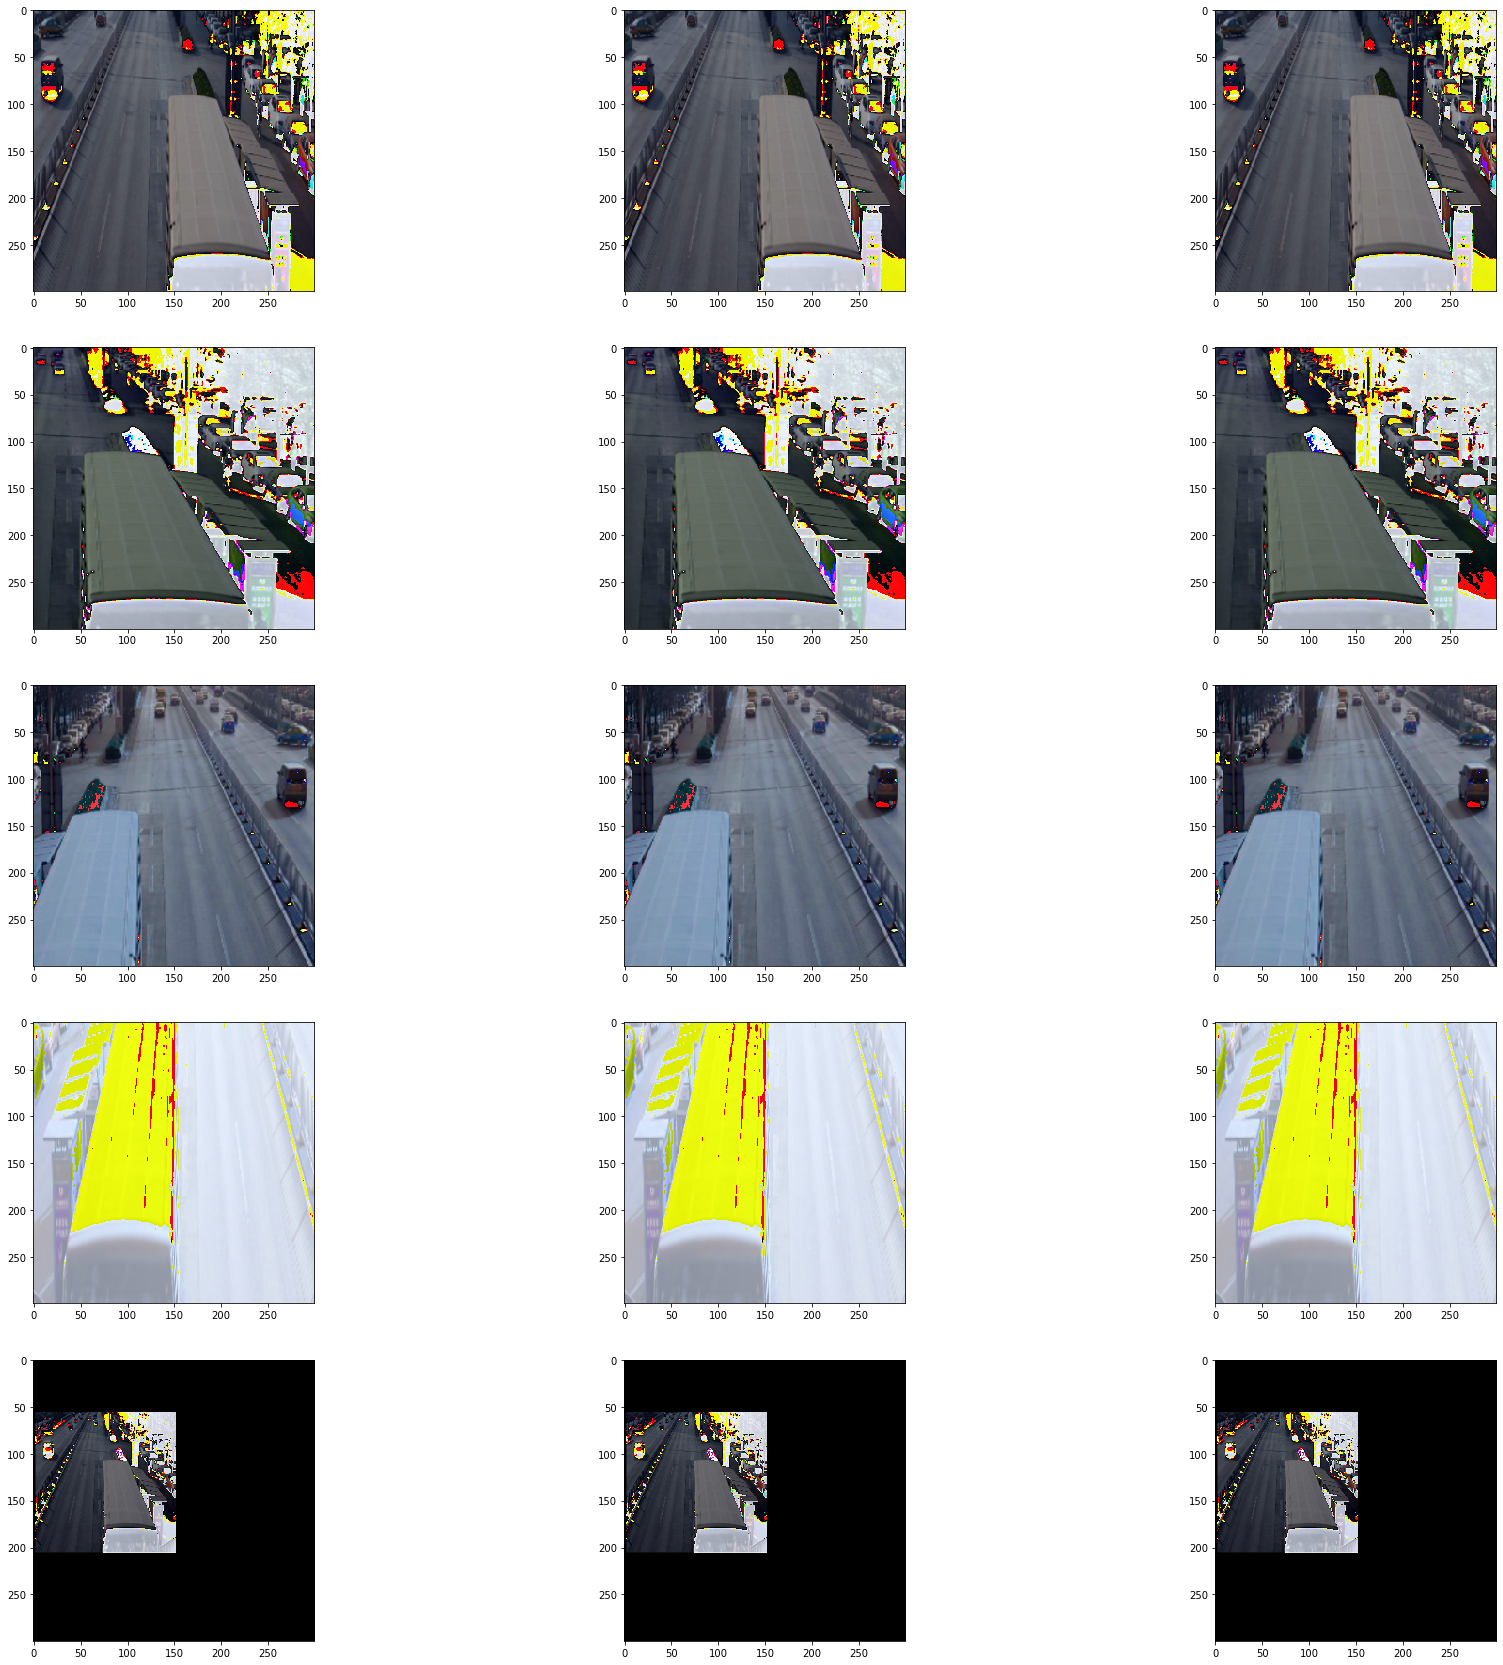

In [70]:
"""
For some reason I can't figure out, rectangles are not being drawn on the images
"""

n_samples = predicted_boxes.size(0)
print(n_samples)
image_size = 300
color = (255, 0,0)

rows = 5
cols = 3
amp = 1

fig, axes = plt.subplots(rows, cols, figsize = (30*amp,30*amp))


for i in range(n_samples):
    img_tmp = np.ndarray(shape = (300,300,3), dtype = np.uint8)
    image = images_cpu[i]
    predicted_boxes_reshaped = predicted_boxes[i][pos_mask[i], :]
    gt_boxes_reshaped = gt_boxes[i][pos_mask[i], :]
    
    
    image = image.permute(1,2,0)
    image_np = image.numpy().astype(np.uint8)
    image_cp = np.copy(image_np)
    
    
    axes[i,0].imshow(image_np)
    n_rects = predicted_boxes_reshaped.size(0)
    pbr = (predicted_boxes_reshaped.numpy() * image_size).astype(np.uint8)
    gbr = (gt_boxes_reshaped.numpy() * image_size).astype(np.uint8)
    for j in range(n_rects):
        #should be left, top, right, bottom
        # let's draw the ground boxes to be sure
        
        cv2.rectangle(image_np, (pbr[j][0], pbr[j][1]), (pbr[j][2], pbr[j][3]), color, 2)
            
    axes[i,1].imshow(image_np)
    
    n_rects = gt_boxes_reshaped.size(0)
    for j in range(n_rects):
        cv2.rectangle(image_cp, (gbr[j][0], gbr[j][1]), (gbr[j][2], gbr[j][3]), color, 2)
        
    
    axes[i,2].imshow(image_cp)
    
    if i == rows - 1:
        break
        


In [172]:
## we want to do things image by image... let's organize the boxes into list
predicted_boxes_list = []
gt_boxes_list = []



pos_mask = labels > 0
predicted_boxes_reshaped = predicted_boxes[pos_mask, :]
print(predicted_boxes_reshaped.size())
gt_boxes_reshaped = gt_boxes[pos_mask, :]
print(gt_boxes_reshaped.size())
## I guess all we need is the statistics so convert them all and then see



torch.Size([86, 4])
torch.Size([86, 4])


## okay we evaluated by frame that boxes actually work (although it doesn't draw...)
## now we are moving onto evaluating the test dataset

In [73]:
## do code evaluation...

all_ground_boxes = []
all_proposed_boxes = []
all_confidence = []
all_labels = []
all_images = []

for _, data in enumerate(test_loader):
    images, boxes, labels = data
    images = images.to(DEVICE)
    boxes = boxes.to(DEVICE)
    labels = labels.to(DEVICE)
    with torch.no_grad():
        confidence, locations = net(images)
        all_proposed_boxes.append(locations)
        all_confidence.append(confidence)
        all_labels.append(labels)
        all_ground_boxes.append(boxes)
        all_images.append(images)
    



In [75]:
# each element in this array will be the batch result

assert(len(all_proposed_boxes) == len(all_confidence))
assert(len(all_proposed_boxes) == len(all_labels))
assert(len(all_proposed_boxes) == len(all_ground_boxes))
assert(len(all_proposed_boxes) == len(all_images))

In [103]:
def compute_stats(gt_boxes, proposed_boxes, iou=0.5):
    assert(gt_boxes.size() == proposed_boxes.size())
    iou_list = ssd_utils.box_utils.iou_of(gt_boxes, proposed_boxes)
    tmp = iou_list > iou
    
    tp = torch.sum(iou_list > iou)
    
    return tp.item(), tmp.size()

import vision.utils as ssd_utils

In [104]:
tp_all = 0
boxes_all = 0

for i, images in enumerate(all_images):
    predicted_locations = all_proposed_boxes[i].cpu()
    predicted_boxes = ssd_utils.box_utils.convert_locations_to_boxes(predicted_locations, config.priors, config.center_variance, config.size_variance)
    predicted_boxes = ssd_utils.box_utils.center_form_to_corner_form(predicted_boxes)

    gt_locations = all_ground_boxes[i].cpu()
    gt_boxes = ssd_utils.box_utils.convert_locations_to_boxes(gt_locations, config.priors, config.center_variance, config.size_variance)
    gt_boxes = ssd_utils.box_utils.center_form_to_corner_form(gt_boxes)

    labels = all_labels[i]
    pos_mask = labels > 0
    predicted_boxes_reshaped = predicted_boxes[pos_mask, :]
    gt_boxes_reshaped = gt_boxes[pos_mask, :]
    tp, all_size = compute_stats(gt_boxes_reshaped, predicted_boxes_reshaped)
    tp_all += tp
    boxes_all += all_size[0]
    
print(1.0 * tp_all / boxes_all)    

0.9267286696320258


In [107]:
print(boxes_all)
print(tp_all)
print(X_test.shape)

12365
11459
(2085, 300, 300, 3)


In [112]:
## looking at the images, I don't think this is a good measure 
## because it creates multiple boxes for each object...
## so we need to figure out a way to eliminate recurring boxes
# let's try evaluation method that is already implemented from eval_ssd.py

from vision.ssd.vgg_ssd import create_vgg_ssd, create_vgg_ssd_predictor


predictor = create_vgg_ssd_predictor(net, nms_method="hard", device=DEVICE)
results = []
dataset = test_dataset
for i in range(len(dataset)):
    print("process image", i)
    timer.start("Load Image")
    image = dataset.get_image(i)
    print("Load Image: {:4f} seconds.".format(timer.end("Load Image")))
    timer.start("Predict")
    boxes, labels, probs = predictor.predict(image)
    print("Prediction: {:4f} seconds.".format(timer.end("Predict")))
    indexes = torch.ones(labels.size(0), 1, dtype=torch.float32) * i
    results.append(torch.cat([
        indexes.reshape(-1, 1),
        labels.reshape(-1, 1).float(),
        probs.reshape(-1, 1),
        boxes   # + 1.0 matlab's indexes start from 1
    ], dim=1))
    
results = torch.cat(results)



process image 0
Load Image: 0.000019 seconds.
Inference time:  0.009671688079833984
Prediction: 0.489269 seconds.
process image 1
Load Image: 0.000005 seconds.
Inference time:  0.005556344985961914
Prediction: 0.487730 seconds.
process image 2
Load Image: 0.000014 seconds.
Inference time:  0.011211633682250977
Prediction: 0.501062 seconds.
process image 3
Load Image: 0.000034 seconds.
Inference time:  0.005454063415527344
Prediction: 0.477616 seconds.
process image 4
Load Image: 0.000015 seconds.
Inference time:  0.00617671012878418
Prediction: 0.551578 seconds.
process image 5
Load Image: 0.000020 seconds.
Inference time:  0.013850927352905273
Prediction: 0.486329 seconds.
process image 6
Load Image: 0.000014 seconds.
Inference time:  0.0061130523681640625
Prediction: 0.540788 seconds.
process image 7
Load Image: 0.000012 seconds.
Inference time:  0.006205558776855469
Prediction: 0.627247 seconds.
process image 8
Load Image: 0.000014 seconds.
Inference time:  0.010448455810546875
Pred

NameError: name 'eval_path' is not defined

In [132]:
print(results.size())
print(results[20000:20010])

torch.Size([5258597, 7])
tensor([[  10.0000,    1.0000,    8.4838,  176.5445,  159.4772, -317.5083,
         -164.4660],
        [  10.0000,    1.0000,    8.4728,    9.6680,  254.2108, -183.7180,
         -747.5223],
        [  10.0000,    1.0000,    8.4727, -146.4826,  282.3518,   61.6044,
         -156.6936],
        [  10.0000,    1.0000,    8.4726,  -47.2241,  -30.1922,  206.7841,
           74.1833],
        [  10.0000,    1.0000,    8.4724, -116.1013,  155.6660, -320.4606,
         -962.5322],
        [  10.0000,    1.0000,    8.4720,  173.6437,  185.7713, -271.9244,
         -201.9420],
        [  10.0000,    1.0000,    8.4665,  -24.0700,  348.7384, -327.5346,
         -591.8228],
        [  10.0000,    1.0000,    8.4661,  -59.4096,  231.4499, -334.5667,
         -654.5791],
        [  10.0000,    1.0000,    8.4658,  -28.7196,  390.3387, -233.4515,
         -876.8799],
        [  10.0000,    1.0000,    8.4652, -211.4818,  222.8013, -426.5144,
         -734.9492]])


In [124]:

class_names = ['car', 'bus', 'others', 'van']

for class_index, class_name in enumerate(class_names):
    if class_index == 0: continue  # ignore background
    sub = results[results[:, 1] == class_index, :]
    for i in range(sub.size(0)):
        prob_box = sub[i, 2:].numpy()
        print(sub[i,2:])  
        print(int(sub[i,0]))
        #image_id = dataset.ids[int(sub[i, 0])]
        image_id = "0"
        print(
            image_id + " " + " ".join([str(v) for v in prob_box])
        )
        break
aps = []
    

print("\n\nAverage Precision Per-class:")
for class_index, class_name in enumerate(class_names):
    iou_threshold = 0.5
    use_2007_metric = True
    ap = compute_average_precision_per_class(
        true_case_stat[class_index],
        all_gb_boxes[class_index],
        all_difficult_cases[class_index],
        prediction_path,
        iou_threshold, 
        use_2007_metric
    )
    aps.append(ap)
    
print(f"\nAverage Precision Across All Classes:{sum(aps)/len(aps)}")

tensor([  12.1336,  -91.4708,  489.7305, -789.1732, -655.6823])
0
0 12.133568 -91.47082 489.7305 -789.1732 -655.68225
tensor([   7.7195,   47.3254, -146.1404,  335.1895,  204.4776])
0
0 7.7195253 47.32538 -146.14035 335.18945 204.47758
tensor([  12.8959,   15.6816, -359.4620,   52.8022, -413.3423])
0
0 12.895852 15.681629 -359.46198 52.802155 -413.34232


Average Precision Per-class:


NameError: name 'true_case_stat' is not defined

In [ ]:
# we need to accumulate the results..
# also if there are squares that are being used multiple times, we need to prevent that bc it's not fair to detect easy ones multiple times to get good numbers
# adapt this some how...
## TODO! This function is not finished...

matched = set()
for i, image_batch in enumerate(all_images):
    predicted_locations = all_proposed_boxes[i].cpu()
    predicted_boxes = ssd_utils.box_utils.convert_locations_to_boxes(predicted_locations, config.priors, config.center_variance, config.size_variance)
    predicted_boxes = ssd_utils.box_utils.center_form_to_corner_form(predicted_boxes)

    gt_locations = all_ground_boxes[i].cpu()
    gt_boxes = ssd_utils.box_utils.convert_locations_to_boxes(gt_locations, config.priors, config.center_variance, config.size_variance)
    gt_boxes = ssd_utils.box_utils.center_form_to_corner_form(gt_boxes)
    labels = all_labels[i]
    
    
    for j in range(image_batch.size(0)):
        image = image_batch[j]
        labels_frame = labels[j]
        gt_boxes_frame = gt_boxes[j]
        predicted_boxes_frame = predicted_boxes[j]
        
        pos_mask = labels_frame > 0
        predicted_boxes_reshaped = predicted_boxes[pos_mask, :]
        gt_boxes_reshaped = gt_boxes[pos_mask, :]
        tp, all_size = compute_stats(gt_boxes_reshaped, predicted_boxes_reshaped)
        tp_all += tp
        boxes_all += all_size[0]
        
for i, image_id in enumerate(image_ids):
    box = boxes[i]
    if image_id not in gt_boxes:
        false_positive[i] = 1
        continue

    gt_box = gt_boxes[image_id]
    ious = box_utils.iou_of(box, gt_box)
    max_iou = torch.max(ious).item() 
    # the only reason you can do this is if you assume there is one box per frame
    # however, uadetrac does not have one frame, it has multiple frames. 
    # we need to look into the transformer to see how everything changes
    max_arg = torch.argmax(ious).item()
    if max_iou > iou_threshold:
        if difficult_cases[image_id][max_arg] == 0:
            if (image_id, max_arg) not in matched:
                true_positive[i] = 1
                matched.add((image_id, max_arg))
            else:
                false_positive[i] = 1
    else:
        false_positive[i] = 1

    true_positive = true_positive.cumsum()
    false_positive = false_positive.cumsum()
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / num_true_cases
    if use_2007_metric:
        return measurements.compute_voc2007_average_precision(precision, recall)
    else:
        return measurements.compute_average_precision(precision, recall)



In [58]:
labels = all_labels[0]
predicted_locations = all_proposed_boxes[0]
gt_locations = all_ground_boxes[0]


In [59]:
import vision.utils as ssd_utils
## need to convert locations to boxes

predicted_locations = all_proposed_boxes[0].cpu()
predicted_boxes = ssd_utils.box_utils.convert_locations_to_boxes(predicted_locations, config.priors, config.center_variance, config.size_variance)
predicted_boxes = ssd_utils.box_utils.center_form_to_corner_form(predicted_boxes)

gt_locations = all_ground_boxes[0].cpu()
gt_boxes = ssd_utils.box_utils.convert_locations_to_boxes(gt_locations, config.priors, config.center_variance, config.size_variance)
gt_boxes = ssd_utils.box_utils.center_form_to_corner_form(gt_boxes)


pos_mask = labels > 0
predicted_boxes_reshaped = predicted_boxes[pos_mask, :]
print(predicted_boxes_reshaped.size())
gt_boxes_reshaped = gt_boxes[pos_mask, :]
print(gt_boxes_reshaped.size())
## I guess all we need is the statistics so convert them all and then see

### okay now we have to start matching??
### -> I don't think we need to manually match
### -> Let's just calculate the final score first to see what's up

def compute_stats(gt_boxes, proposed_boxes, iou=0.5):
    assert(gt_boxes.size() == proposed_boxes.size())
    iou_list = ssd_utils.box_utils.iou_of(gt_boxes, predicted_boxes)
    tmp = iou_list > iou
    print(tmp)
    
    tp = torch.sum(iou_list > iou)
    return tp

print(compute_stats(gt_boxes, predicted_boxes))


torch.Size([232, 4])
torch.Size([232, 4])


In [ ]:
## Essentially, it is saying that there is no box that overlaps with the original image.
## I find this hard to believe and want to categorize the boxes into its corresponding image



In [62]:

### okay now we have to start matching??
### -> I don't think we need to manually match
### -> Let's just calculate the final score first to see what's up

def compute_stats(gt_boxes, proposed_boxes, iou=0.5):
    assert(gt_boxes.size() == proposed_boxes.size())
    iou_list = ssd_utils.box_utils.iou_of(gt_boxes, predicted_boxes)
    tmp = iou_list > iou
    print(tmp)
    
    tp = torch.sum(iou_list > iou)
    return tp


    
    

In [63]:
print(compute_stats(gt_boxes, predicted_boxes))

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
tensor(1007)


In [50]:
print(smooth_l1_loss)
print(num_pos)

tensor(356.8410, device='cuda:0')
107


In [52]:
print(predicted_locations.size())
print(gt_locations.size())

torch.Size([107, 4])
torch.Size([107, 4])


In [ ]:
## probably make a converting function....
# proposed_boxes = convertssd2ml(all_locations)



In [ ]:
### after training on UA-detrac, let's do some evaluation!
## Use the functions available from utils

precision, recall = corloc(test_boxes, proposed_boxes, iou = 0.5)
print(precision)
print(recall)

In [ ]:
### after filtering
filtered_test_boxes = filter_ground_truth(test_boxes)

precision, recall = corloc(filtered_test_boxes, proposed_boxes, iou = 0.5)
print(precision)
print(recall)

In [ ]:
### visualization

from utils import *

rows = 5
cols = 3
size = 30
n_samples = test_images.shape[0]
fig, axes = plt.subplots(rows, cols, figsize = (size*cols, size*rows), sharex = True, sharey = True)

for i in range(rows):
    random_index = random.randint(0, n_samples)
    axes[i, 0].imshow(test_images[random_index])
    cv_patches = ml2cv_patches(filtered_test_boxes[random_index])
    ground_image = draw_patches(test_images[random_index], cv_patches)
    axes[i, 1].imshow(ground_image)
    cv_patches2 = ml2cv_patches(proposed_boxes[random_index])
    proposed_image = draw_patches(test_images[random_index], cv_patches2)
    axes[i, 2].imshow(proposed_image)
    print("row", i)
    precision, recall = corloc([filtered_test_boxes[random_index]], [proposed_boxes[random_index]], iou = 0.5)
    print("  precision:", precision, " recall:", recall)
    
    